# Modelo Lineal Regularizado

A un determinado modelo con ciertas restricciones que dependen directamente del problema a tratar. Es decir, de manera simplista expresemos un problema de ajustes de curvas para el precio de vivienda en california, que es una base de datos muy común de trabajar es posible que tenga restricciones que solo los vendedores conozcan, por tal motivo se tienen que traducir de forma matemática para poder que nuestro modelo sea capaza de ajustarse con las restricciones implícitas en el problema.


El proceso de ajuste generalmente implica minimizar o maximizar lo que se llama la función, lo que llamamos "función objetiva". El grupo de funciones que se minimizan se denominan "funciones de pérdida". Una función de pérdida es una medida de qué tan bueno es un modelo de predicción en términos de poder predecir el resultado esperado. Un método más utilizado para encontrar el punto mínimo de función es el "descenso de gradiente". Pensar en la función de pérdida, como la montaña ondulada y el descenso de gradiente, es como deslizarse por la montaña para llegar al punto más bajo.<a href="https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0">[1]</a>.

No hay una sola función de pérdida que funcione para todo tipo de datos. Depende de una serie de factores que incluyen la presencia de valores atípicos, la elección del algoritmo de aprendizaje automático, la eficiencia de tiempo del descenso del gradiente, la facilidad para encontrar los derivados y la confianza de las predicciones.En esta Sección describimos formalmente el problema de la regresión lineal, o el ajuste de una línea representativa (o hiperplano en dimensiones más altas) a un conjunto de puntos de datos de entrada / salida,  a partir de las librerías de Scikit-learn.ademas como las diferentes funciones de pérdida afectan al modelo de regrecion. 


In [64]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge

Supongamos que tiene muchas características para un problema en particular . Y sabe que la salida que está intentando predecir es una combinación lineal de estas características. El caso de uso clásico del que hablan la mayoría de los tutoriales es predecir el precio de una casa en función de varias características $(x_{i})$ de una casa, donde las características varían desde la ubicación hasta los tipos de techo y el área y otros. La predicción del precio $(y)$, representada por la función $h (x) $ se vería de la siguiente manera:


In [65]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

#La semilla es para cuando queremos resultados repetibles numeros estables
np.random.seed

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "imagesAM", CHAPTER_ID)
HOUSING_PATH = "datasets/housing/"


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [135]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

for train_index, test_index in split.split(housing, housing["income_cat"].values):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


housing = strat_train_set.copy()


try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

housing_num = housing.drop('ocean_proximity', axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()), #MinMaxScaler StandardScaler
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)


try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), #OneHotEncoder or OrdinalEncoder()
    ])

housing_prepared = full_pipeline.fit_transform(housing)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
housing_labels=stats.zscore(housing_labels)
housing_num_tr.shape
housing_labels

X=housing_num_tr[0:300,7:8]
Y=housing_labels[0:300]


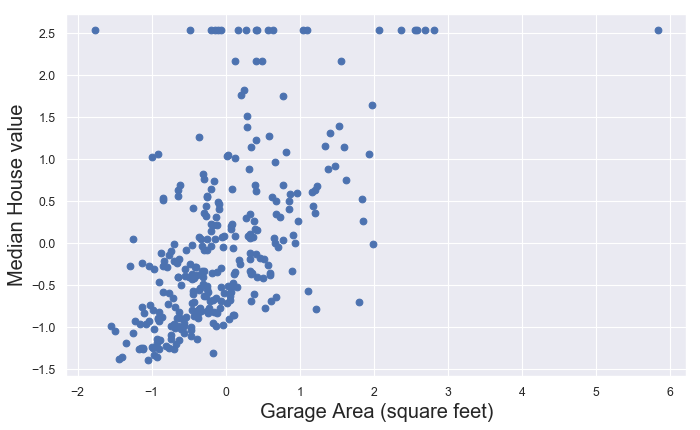

In [148]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(X,Y, marker = 'o', linestyle = '')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.show()

Estos conjuntos de datos son de la competencia de los precios de la vivienda, pero el propósito de este Cuaderno es aprender y experimentar con modelos lineales regularizados. Primero, elegiremos una sola variable independiente para fines de visualización y probaremos diferentes modelos lineales regularizados. Más adelante expandiremos los modelos a múltiples variables independientes. La descripción de los datos está disponible aquí: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

# Modelos de una sola variable (con fines ilustrativos) 
Simplificamos los datos para fines de ilustración e introducción de los modelos regularizados. Más adelante incluiremos múltiples variables en los modelos

Equation of Best Fit Line:
Y = [0.67027609]x + 0.011668411074467257


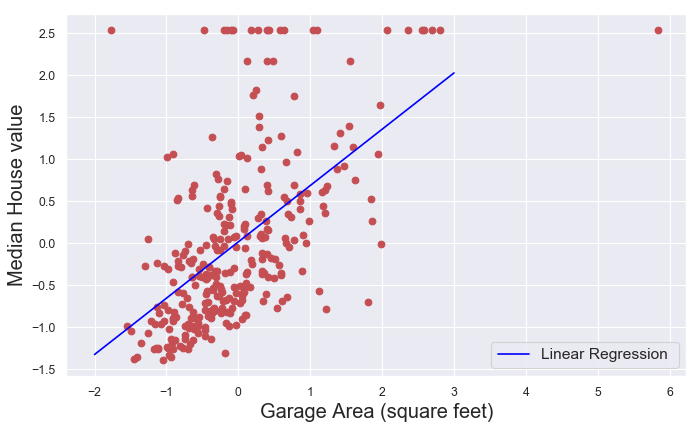

In [154]:
import seaborn as sns; sns.set(color_codes=True)
# linear regression
reg = LinearRegression()
fit =reg.fit(X, Y)

# predict
xFit= np.linspace(-2,3,num=300).reshape(-1,1)
yFit = reg.predict(xFit)

print ("Equation of Best Fit Line:")
print ("Y = %sx + %s" % (reg.coef_,reg.intercept_))
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit ,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()  


Transformar las características de entrada de forma no lineal 

In [137]:
from sklearn.preprocessing import PolynomialFeatures
# Transform the input features
Poly = PolynomialFeatures(degree = 10, include_bias = False)
xTrainPoly = Poly.fit_transform(X)

Es una fórmula que permite la estandarización de una distribución. sta fórmula se calcula restando al dato, la media de la distribución y dividiendo el resultado por la desviación típica (la distancia que tiene dicho dato respecto de la media).

In [138]:
from sklearn.preprocessing import StandardScaler
# standardization
scaler = StandardScaler()
xTrainPolyStan = scaler.fit_transform(xTrainPoly)


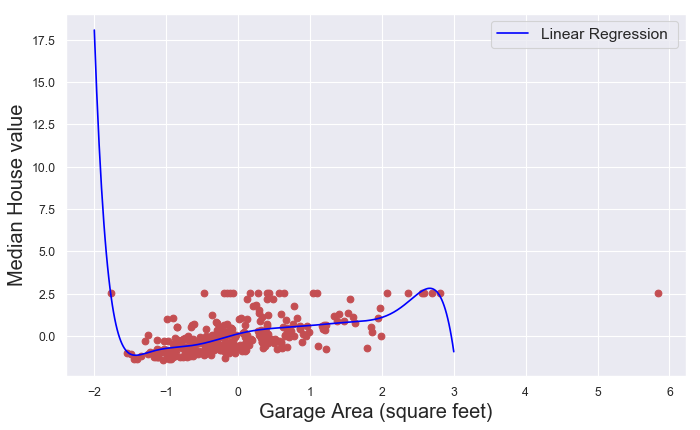

In [163]:
# linear regression
reg = LinearRegression()
fit =reg.fit(xTrainPolyStan, Y)

# predict
xFit_poli = np.linspace(-2,3,num=300).reshape(-1,1)
xFitPoly = Poly.transform(xFit_poli )
xFitPolyStan = scaler.transform(xFitPoly)
yFit_poli  = reg.predict(xFitPolyStan)

pred = reg.predict(xTrainPolyStan)
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli ,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()


# Ridge Regression
Regular linear regression has the form of: 
J(theta) = MSE(theta) 

Ridge regression appy a regularization term proportional to the square of l2-norm of feature weights (not including the intercept). A common expression is: 
$J(theta) = MSE(theta) + alpha 1/2 (theta_1^2 + theta_2^2 + ... + theta_n^2)$

The corrsponding expression for gradient of theta and the optimal solution for theta will change, due to the additonal term. We can also use the Scikit-Learn package to do ridge regression.

Equation of Best Fit Ridge Regression:10
Y = [0.64202204]x + 0.01066278117913584
Equation of Best Fit Ridge Regression:30
Y = [0.59210427]x + 0.008886087193316192
Equation of Best Fit Ridge Regression:100
Y = [0.46544392]x + 0.004377939872387092


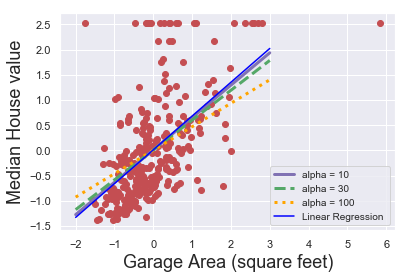

In [159]:
i=0
ls = ['-','--',':']
color = ['m','g','orange']

for a in [10,30,100]:
    ridgeReg = Ridge(alpha=a)
    ridgeReg.fit(X, Y)
    print ("Equation of Best Fit Ridge Regression:%d"%(a))
    print ("Y = %sx + %s" % (ridgeReg.coef_,ridgeReg.intercept_))
    # predict
    xFit_predridgeRe= np.linspace(-2,3,num=300).reshape(-1,1)
    yFit_predridgeRe = ridgeReg.predict(xFit_predridgeRe)
 
    # plot 
    plt.plot(xFit_predridgeRe, yFit_predridgeRe, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show()    


Ridge Regression no lineal 

Equation of Best Fit Ridge Regression:0
Y = [ 0.83509263 -0.68632551 -2.61811105 10.66637701 -4.43064632 -0.0682888
 -1.72370627 -0.64374388 -0.54218474 -0.24732415]x + -0.012188332027970516
Equation of Best Fit Ridge Regression:0
Y = [  0.74844389  -1.10201434  -0.6198452   14.25654194 -27.62970316
  33.70685614 -26.72835894   0.2870893   -1.3374866    8.90651094]x + -0.012188332027968308
Equation of Best Fit Ridge Regression:1
Y = [ 0.62329291  0.03507952 -0.32037246  0.82951547  0.06751178  0.02879306
 -0.13532351 -0.17495226 -0.2073077  -0.21848168]x + -0.01218833202797068


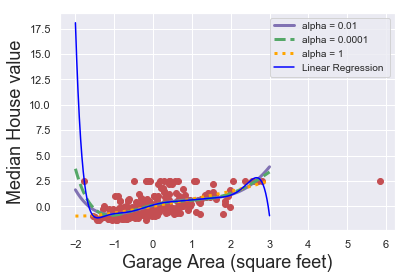

In [176]:
i=0
ls = ['-','--',':']
color = ['m','g','orange']

for a in [0.01,0.0001,1]:
    ridgeReg = Ridge(alpha=a)
    ridgeReg.fit(xTrainPolyStan, Y)
    print ("Equation of Best Fit Ridge Regression:%d"%(a))
    print ("Y = %sx + %s" % (ridgeReg.coef_,ridgeReg.intercept_))
    # predict
    xFit_poli_ridgeReg= np.linspace(-2,3,num=300).reshape(-1,1)
    xFitPoly_ridgeReg = Poly.transform(xFit_poli_ridgeReg)
    xFitPolyStan_ridgeReg = scaler.transform(xFitPoly_ridgeReg)
    yFit_poli_ridgeReg  = ridgeReg.predict(xFitPolyStan_ridgeReg)
   
    # plot 
    plt.plot(xFit_poli_ridgeReg, yFit_poli_ridgeReg, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show() 


# Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression - LASSO 
Cost function: J(theta) = MSE(theta) + alpha (|theta_1| + |theta_2| + ... + |theta_n|). The penalty is proportional to the l1-norm of theta. 

The advantage of Lasso over ridge regression lies in the diamond shape of contour of the l1-norm penalty, which leads to some of the thetas being eliminated (set to 0) quickly. This means the Lasso regression can perform automatic feature selection, when ridge regression cannot. If you have the book Hands-on Machine Learning with Scikit-Learn & Tensorflow, Figure 4-19 gives a more detailed explanation of the feature selection capability of Lass0. You can also understand the difference of ridge and Lasso regression by understanding that, ridge's l2-penalty heavily penalizes large thetas, but has nearly no penalization for small thetas (due to the square), whereas Lasso's l1-penalty gives appropriate penalization to even small theta

Equation of Best Fit Lasso:0
Y = [0.51184759]x + 0.006029558506995313
Equation of Best Fit Lasso:0
Y = [0.65707372]x + 0.011198506693844578
Equation of Best Fit Lasso:10
Y = [0.]x + -0.012188332027970648


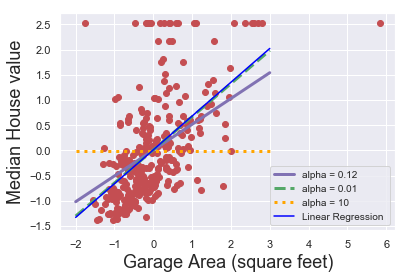

In [185]:
i=0
ls = ['-','--',':']
color = ['M','g','orange']

for a in [0.12,0.01,10]:
    lassoReg = Lasso(alpha=a)
    lassoReg.fit(X, Y)
    # predict
    xFit_lassoReg= np.linspace(-2,3,num=300).reshape(-1,1)
    yFit_lassoReg = lassoReg.predict(xFit_lassoReg)
    print ("Equation of Best Fit Lasso:%d"%(a))
    print ("Y = %sx + %s" % ( lassoReg.coef_, lassoReg.intercept_))
    # plot 
    plt.plot(xFit_lassoReg, yFit_lassoReg, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    
    
plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show()    


Lasso Regression no lineal

C:\Users\nyquist\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Equation of Best Fit Lasso:0
Y = [ 0.64518658 -0.04349004 -0.55344528  1.98143586 -0.55694888 -0.11961772
 -0.54667812 -0.13164506 -0.10795075 -0.03732366]x + -0.01218833202797066
Equation of Best Fit Lasso:5
Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]x + -0.012188332027970648
Equation of Best Fit Lasso:10
Y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]x + -0.012188332027970648


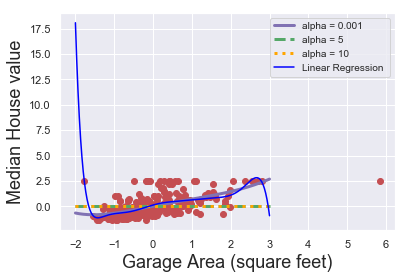

In [199]:
i=0
ls = ['-','--',':']
color = ['M','g','orange']

for a in [0.001,5,10]:
    lassoReg = Lasso(alpha=a)
    lassoReg.fit(xTrainPolyStan, Y)
    # predict
    xFit_poli_lassoReg= np.linspace(-2,3,num=300).reshape(-1,1)
    xFitPoly_lassoReg = Poly.transform(xFit_poli_lassoReg)
    xFitPolyStan_lassoReg = scaler.transform(xFitPoly_lassoReg )
    yFit_poli_lassoReg  = lassoReg.predict(xFitPolyStan_lassoReg)
    print ("Equation of Best Fit Lasso:%d"%(a))
    print ("Y = %sx + %s" % ( lassoReg.coef_, lassoReg.intercept_))
    # plot 
    plt.plot(xFit_poli_lassoReg, yFit_poli_lassoReg, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    
    
plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli,label='Linear Regression ',color='blue')
plt.ylabel('Median House value', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show()    


# ElasticNet

Equation of Best Fit elasticReg:0
Y = [0.58729099]x + 0.008714771202581044
Equation of Best Fit elasticReg:1
Y = [0.53825234]x + 0.0069693672682406334
Equation of Best Fit elasticReg:100
Y = [-0.]x + -0.012188332027970648


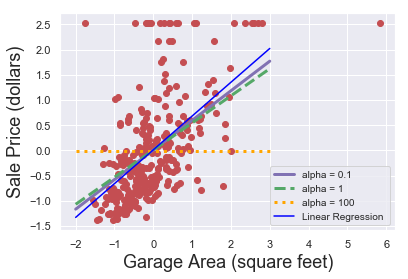

In [220]:
i=0
ls = ['-','--',':']
color = ['m','g','orange']

for a in [0.1,1,100]:
    elasticReg = ElasticNet(alpha = 0.1, l1_ratio = a)
    elasticReg.fit(X, Y)
    # predict
    xFit_elasticReg= np.linspace(-2,3,num=300).reshape(-1,1)
    yFit_elasticReg = elasticReg.predict(xFit_elasticReg)
    print ("Equation of Best Fit elasticReg:%d"%(a))
    print ("Y = %sx + %s" % (elasticReg.coef_,elasticReg.intercept_))
    # plot 
    plt.plot(xFit_elasticReg,yFit_elasticReg, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    
    
plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit,label='Linear Regression ',color='blue')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show()    




# KernelRidge rbf

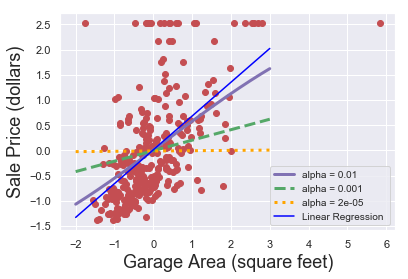

In [239]:
i=0
ls = ['-','--',':']
color = ['m','g','orange']

for a in [0.01,0.001 ,0.00002]:
    KernelRig= KernelRidge(kernel='rbf', gamma=a)
    KernelRig.fit(X, Y)
    xFit_KernelRig= np.linspace(-2,3,num=300).reshape(-1,1)
    yFit_KernelRig = KernelRig.predict(xFit_elasticReg)
    # plot 
    plt.plot(xFit_KernelRig,yFit_KernelRig, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit,label='Linear Regression ',color='blue')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show() 



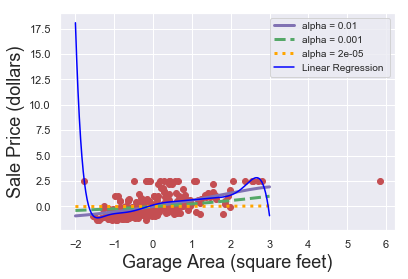

In [243]:
i=0
ls = ['-','--',':']
color = ['m','g','orange']

for a in [0.01,0.001 ,0.00002]:
    KernelRig= KernelRidge(kernel='rbf', gamma=a)
    KernelRig.fit(xTrainPolyStan, Y)
    
    xFit_KernelRig= np.linspace(-2,3,num=300).reshape(-1,1)
    xFitPoly_KernelRig = Poly.transform(xFit_KernelRig )
    xFitPolyStan_KernelRig = scaler.transform(xFitPoly_KernelRig )
    yFit_KernelRig = KernelRig.predict(xFitPolyStan_KernelRig)
    # plot 
    plt.plot(xFit_KernelRig,yFit_KernelRig, lw=3, color=color[i], zorder = 2, label= "alpha = " + str(a),linestyle=ls[i])
    i = i + 1
    

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli,label='Linear Regression ',color='blue')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(fontsize = 10)
plt.show() 



# KernelRidge linear

(300,)

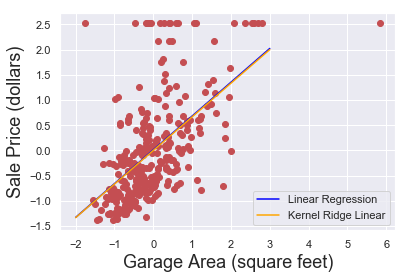

In [247]:

KernelRig_l= KernelRidge(kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)
KernelRig_l.fit(X, Y)
xFit_KernelRig_l= np.linspace(-2,3,num=300).reshape(-1,1)
yFit_KernelRig_l= KernelRig_l.predict(xFit_KernelRig_l)

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit,yFit,label='Linear Regression ',color='blue')
plt.plot(xFit_KernelRig_l,yFit_KernelRig_l,label='Kernel Ridge Linear',color='orange')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(loc='lower right')

Y.shape

# Bayesian Ridge Regression

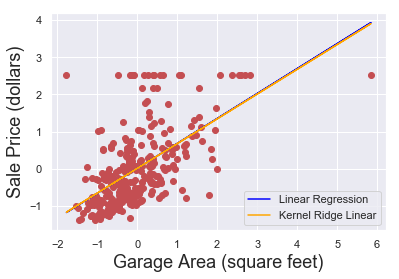

In [12]:
from sklearn.linear_model import BayesianRidge
ridBayesianRidge =BayesianRidge(compute_score=True)
ridBayesianRidge.fit(X, Y)
predeBayesianRidge = ridBayesianRidge.predict(X) 

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(X,pred,label='Linear Regression ',color='blue')
plt.plot(X,predeBayesianRidge,label='Kernel Ridge Linear',color='orange')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(loc='lower right')


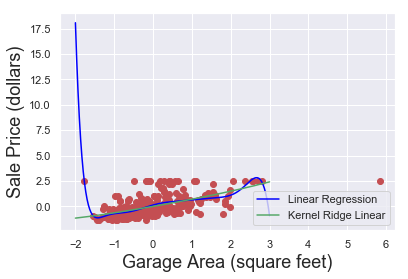

In [258]:
from sklearn.linear_model import BayesianRidge

ridBayesianRidge =BayesianRidge(compute_score=True)
ridBayesianRidge.fit(xTrainPolyStan, Y)

xFit_BayesianRidge= np.linspace(-2,3,num=300).reshape(-1,1)
xFitPoly_BayesianRidge= Poly.transform(xFit_BayesianRidge)
xFitPolyStan_BayesianRidge = scaler.transform(xFitPoly_BayesianRidge)
yFit_BayesianRidge = ridBayesianRidge.predict(xFitPolyStan_BayesianRidge )


plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli,label='Linear Regression ',color='blue')
plt.plot(xFit_BayesianRidge,yFit_BayesianRidge,label='Kernel Ridge Linear',color='g')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(loc='lower right')


# Automatic Relevance Determination Regression (ARD)

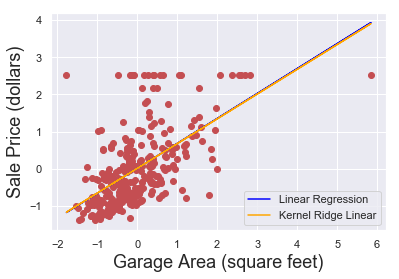

In [14]:
from sklearn.linear_model import ARDRegression
ridARD =ARDRegression(compute_score=True)
ridARD.fit(X, Y)
predeARD = ridARD.predict(X) 

plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(X,pred,label='Linear Regression ',color='blue')
plt.plot(X,predeARD,label='Kernel Ridge Linear',color='orange')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(loc='lower right')


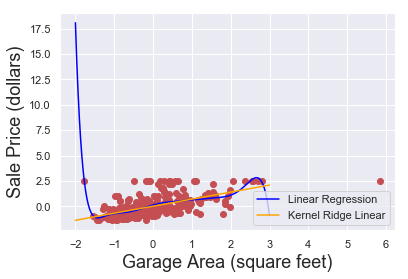

In [263]:
from sklearn.linear_model import ARDRegression
ridARD =ARDRegression(threshold_lambda=1e5)
ridARD.fit(xTrainPolyStan, Y)

xFit_ARD= np.linspace(-2,3,num=300).reshape(-1,1)
xFitPoly_ARD= Poly.transform(xFit_ARD)
xFitPolyStan_ARD= scaler.transform(xFitPoly_ARD)
yFit_ARD = ridARD.predict(xFitPolyStan_ARD )


plt.plot(X, Y, marker = 'o', color = 'R', linestyle = '', zorder = 1)
plt.plot(xFit_poli,yFit_poli,label='Linear Regression ',color='blue')
plt.plot(xFit_ARD,yFit_ARD,label='Kernel Ridge Linear',color='orange')
plt.ylabel('Sale Price (dollars)', fontsize = 18)
plt.xlabel('Garage Area (square feet)', fontsize = 18)
plt.legend(loc='lower right')
